# Visualizing Time Series of the Gini Coefficients

### Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import interp1d
import scipy.integrate as si

### Reading the Data

In [2]:
# reading the data and looking at the head
df = pd.read_csv('income_shares.csv')
df.head()

,Share of Aggregate Income Received by Each Fifth and Top 5 Percent of All Households: 1967 to 2019,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Year,Number of Households (thousands),Lowest\nfifth,Second\nfifth,Third\nfifth,Fourth\nfifth,Highest\nfifth,Top 5\npercent
1,2019,"128,451",3.1,8.3,14.1,22.7,51.9,23
2,2018,"128,579",3.1,8.3,14.1,22.6,52,23.1
3,2017,"127,586",3.1,8.2,14.3,23,51.5,22.3
4,2016,"126,224",3.1,8.3,14.2,22.9,51.5,22.6


### Cleaning the Data

In [3]:
# renaming the columns 
df.rename(columns={
    df.columns[0]: 'Year',
    df.columns[2]:'0 - 20%',
    df.columns[3]:'20 - 40%',
    df.columns[4]:'40 - 60%',
    df.columns[5]:'60 - 80%',
    df.columns[6]:'80 - 100%'}, inplace=True)
df.head()

,Year,Unnamed: 1,0 - 20%,20 - 40%,40 - 60%,60 - 80%,80 - 100%,Unnamed: 7
0,Year,Number of Households (thousands),Lowest\nfifth,Second\nfifth,Third\nfifth,Fourth\nfifth,Highest\nfifth,Top 5\npercent
1,2019,"128,451",3.1,8.3,14.1,22.7,51.9,23
2,2018,"128,579",3.1,8.3,14.1,22.6,52,23.1
3,2017,"127,586",3.1,8.2,14.3,23,51.5,22.3
4,2016,"126,224",3.1,8.3,14.2,22.9,51.5,22.6


In [4]:
# removing first row and resetting index
df = df.iloc[1:54]
df.reset_index(drop=True, inplace=True)
df.head()

,Year,Unnamed: 1,0 - 20%,20 - 40%,40 - 60%,60 - 80%,80 - 100%,Unnamed: 7
0,2019,"128,451",3.1,8.3,14.1,22.7,51.9,23
1,2018,"128,579",3.1,8.3,14.1,22.6,52,23.1
2,2017,"127,586",3.1,8.2,14.3,23,51.5,22.3
3,2016,"126,224",3.1,8.3,14.2,22.9,51.5,22.6
4,2015,"125,819",3.1,8.2,14.3,23.2,51.1,22.1


In [5]:
# creating a zeros columns for calculating gini coefficient 
df['0'] = np.zeros(53)
df.head()

,Year,Unnamed: 1,0 - 20%,20 - 40%,40 - 60%,60 - 80%,80 - 100%,Unnamed: 7,0
0,2019,"128,451",3.1,8.3,14.1,22.7,51.9,23,0.0
1,2018,"128,579",3.1,8.3,14.1,22.6,52,23.1,0.0
2,2017,"127,586",3.1,8.2,14.3,23,51.5,22.3,0.0
3,2016,"126,224",3.1,8.3,14.2,22.9,51.5,22.6,0.0
4,2015,"125,819",3.1,8.2,14.3,23.2,51.1,22.1,0.0


In [6]:
# keeping only relevant columns
df = df[['Year','0', '0 - 20%', '20 - 40%','40 - 60%','60 - 80%','80 - 100%',]]
df.head()

,Year,0,0 - 20%,20 - 40%,40 - 60%,60 - 80%,80 - 100%
0,2019,0.0,3.1,8.3,14.1,22.7,51.9
1,2018,0.0,3.1,8.3,14.1,22.6,52
2,2017,0.0,3.1,8.2,14.3,23,51.5
3,2016,0.0,3.1,8.3,14.2,22.9,51.5
4,2015,0.0,3.1,8.2,14.3,23.2,51.1


In [7]:
# looking at the data types
df.dtypes

Year          object
0            float64
0 - 20%       object
20 - 40%      object
40 - 60%      object
60 - 80%      object
80 - 100%     object
dtype: object

In [8]:
# changing data types from string/objects to ints and floats
df = df.astype({'Year': int,
                '0 - 20%': float,
                '20 - 40%': float,
                '40 - 60%': float,
                '60 - 80%': float,
                '80 - 100%': float})
df.dtypes

Year           int64
0            float64
0 - 20%      float64
20 - 40%     float64
40 - 60%     float64
60 - 80%     float64
80 - 100%    float64
dtype: object

### Function to Create Cumalative Income Shares (Y axis of Lorenz Curve)

In [9]:
# function to get cumalative income shares
def cumalative(dataframe: pd.DataFrame):

    # creating an array from df
    list = np.array(dataframe/dataframe.sum())

    # intialize previous value to create cumalative value
    previous = 0

    # iterate through list, if first year, then skips, else then it adds previous years' value to current year
    for i in range(len(list)):
        if i == 0:
            previous = list[i]
            continue

        else:
            list[i] = list[i] + previous
            previous = list[i]
            
    # return the df row as a numpy arraw that is cumalaitve
    return np.array(list)

### Function to Calculate Gini Coefficients

In [10]:
# function to calculate the gini coefficient
def GiniCalculator(entire_dataframe: pd.DataFrame):

    ginis = []
    x = np.linspace(0,1,6)
    y =  np.linspace(0,1,6)

    # loop each row in df to get the cumalative income percentages,
    # then calculate the gini coefficent, returns list of gini coefficents
    for row in range(len(entire_dataframe)):

        lorenz_curve = cumalative(entire_dataframe.iloc[row][1:8])
        equality_area = np.trapz(y, x=x)
        lorenz_area = np.trapz(lorenz_curve, x= x)
        
        gini = (equality_area - lorenz_area) / float(equality_area)
        ginis.append(gini)
        
    return ginis

### Developing the Plot

In [11]:
def plot():
    # plotting
    plt.grid(which= 'both')
    plt.xlabel('Year')
    plt.ylabel('Gini Coefficient')
    plt.title('Time Series of Gini Coefficents from 1967 - 2019')
    plt.plot(df['Year'], GiniCalculator(df))
    plt.show()
    return

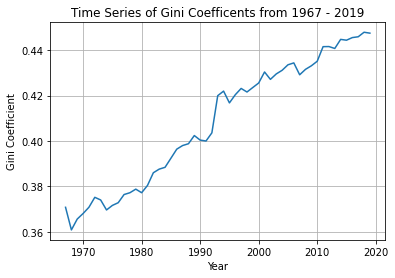

In [12]:
plot()

## Important Notes:

#### Values are very close to the FRED graph and shape is exactly the same

#### The exact values of the Gini coefficients in my analysis differ slightly from the FRED visualization. This is because the data I used has a starting time of 1967 (t = 0), whereas the FRED data has a starting time of 1947 (t = 0). Consequently, the Gini coefficient for 1967 in the FRED data is based on the previous years, while mine is not. Hence, the axes of my graph and the FRED graph are slightly different.